# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [1]:
!pip show torch

Name: torch
Version: 2.7.1+cu128
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\users\andy\dl_ass2\.venv\lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchvision


In [2]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [3]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from collections import Counter
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

c:\Users\Andy\DL_ass2\.venv\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Andy\DL_ass2\.venv\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(
c:\Users\Andy\DL_ass2\.venv\lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
c:\Users\Andy\DL_ass2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebo

In [4]:
## For colab
# from google.colab import drive
# drive.mount('/content/drive')
dataset_dir = "ass2_data"

In [5]:
pos_data_path = os.path.join(dataset_dir, "pos_data.pkl")
type_data_path = os.path.join(dataset_dir, "type_data.pkl")
smiles_data_path = os.path.join(dataset_dir, "smiles.pkl")
data_split_path = os.path.join(dataset_dir, "data_split.npz")
formation_energy_path = os.path.join(dataset_dir, "formation_energy.npz")
with open(pos_data_path, 'rb') as f:
    pos_data = pickle.load(f)

with open(type_data_path, 'rb') as f:
    type_data = pickle.load(f)

with open(smiles_data_path, 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load(data_split_path)

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

train_idxes, val_idxes = train_test_split(
    train_idxes, test_size=0.1, random_state=42
)
formation_energy = np.load(formation_energy_path)

fe = formation_energy['y'] # normalized formation energy
fe_tensor = torch.tensor(fe, dtype=torch.float32) # Convert to tensor
mu = formation_energy['mu']
std = formation_energy['sigma']
print("Target tensor shape:", fe_tensor.shape)
print(f"Train size: {len(train_idxes)} | Val size: {len(val_idxes)} | Test size: {len(test_idxes)}")
print("Example target (train):", fe_tensor[train_idxes[0]])

Target tensor shape: torch.Size([129012])
Train size: 107110 | Val size: 11902 | Test size: 10000
Example target (train): tensor(-0.4042)


In [6]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 107110, test: 10000, sum: 117110


In [7]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


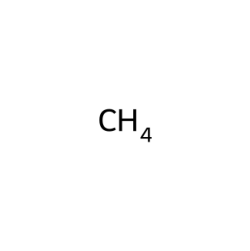

In [8]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.035│     1.510│    -0.381
  C  │  6   │    -0.133│     0.018│    -0.054
  C  │  6   │     0.888│    -0.428│     1.002
  C  │  6   │     0.774│    -1.913│     1.337
  C  │  6   │     1.683│    -2.610│     2.419
  C  │  6   │     2.319│    -1.677│     3.446
  C  │  6   │     0.433│    -3.376│     2.962
  C  │  6   │    -0.437│    -2.410│     2.143
  O  │  8   │    -1.587│    -2.077│     2.200
  H  │  1   │     0.959│     1.770│    -0.762
  H  │  1   │    -0.769│     1.800│    -1.140
  H  │  1   │    -0.218│     2.123│     0.508
  H  │  1   │    -1.139│    -0.223│     0.306
  H  │  1   │     0.016│    -0.570│    -0.970
  H  │  1   │     1.906│    -0.216│     0.645
  H  │  1   │     0.751│     0.169│     1.911
  H  │  1   │     0.818│    -2.501│     0.409
  H  │  1   │     2.447│    -3.259│     1.985
  H  │  1   │     1.570│    -1.045│     3.937
  H  │  1   │     2.824│    -2.254

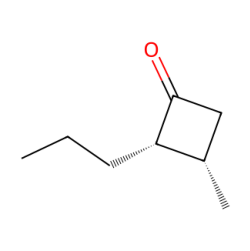

In [9]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

## Task 1

In [10]:
# Task 1, Tokenize character by character

all_chars = [char for smile in smiles_data for char in smile] # Flattens chars
vocab = sorted(set(all_chars))
vocab = ['<PAD>', '<UNK>'] + vocab
token_to_idx = {token: idx for idx, token in enumerate(vocab)}

def smiles_to_sequence(smile):
    return [token_to_idx.get(char, token_to_idx['<UNK>']) for char in smile]

tokenized = [smiles_to_sequence(s) for s in smiles_data]
max_len = max(len(seq) for seq in tokenized)
padded = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(seq) for seq in tokenized],
    batch_first=True,
    padding_value=token_to_idx['<PAD>']
)
print(f"Vocab size: {len(vocab)}")
print(f"Max SMILES length: {max_len}")
print("Example (index 0):", padded[0])

Vocab size: 26
Max SMILES length: 62
Example (index 0): tensor([15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0])


In [11]:
class SmilesDataset(Dataset):
  def __init__(self, smiles_tensor, energy_tensor, indicies):
    self.smiles_tensor = smiles_tensor[indicies]
    self.energy_tensor = energy_tensor[indicies]

  def __len__(self):
    return len(self.energy_tensor)

  def __getitem__(self, idx):
      return self.smiles_tensor[idx], self.energy_tensor[idx]

train_dataset = SmilesDataset(padded, fe_tensor, train_idxes)
val_dataset   = SmilesDataset(padded, fe_tensor, val_idxes)
test_dataset  = SmilesDataset(padded, fe_tensor, test_idxes)

BS = 128
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS)
test_loader = DataLoader(test_dataset, batch_size=BS)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 837
Validation batches: 93
Test batches: 79


In [12]:
class SMILESEnergyPredictor(nn.Module):
  def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=token_to_idx['<PAD>'])
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, 1)
  def forward(self, x):
    emb = self.embedding(x)
    output, (h_n, _) = self.lstm(emb)
    out = self.fc(h_n.squeeze(0))
    return out.squeeze(1)



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_smiles_model(model, train_loader, val_loader, epochs=10):
  best_val_loss = float('inf')
  for epoch in range(epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for x_batch, y_batch in train_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      preds = model(x_batch)
      loss = criterion(preds, y_batch)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * x_batch.size(0)
      pbar.set_postfix(train_loss=loss.item())
    train_loss /= len(train_loader.dataset)

    # Val
    model.eval()
    val_loss = 0
    with torch.no_grad():
      for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        val_loss += loss.item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      # torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/ass2/models/smiles_model.pth")
    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")





In [14]:
train_smiles_model(model, train_loader, val_loader, epochs=10)

Epoch 1/10:   0%|          | 0/837 [00:05<?, ?it/s, train_loss=0.917]

Epoch  1 | Train Loss: 1.0033 | Val Loss: 1.0109


Epoch  2 | Train Loss: 1.0030 | Val Loss: 1.0108


Epoch 3/10:   0%|          | 0/837 [00:04<?, ?it/s, train_loss=0.0113] 

Epoch  3 | Train Loss: 0.2340 | Val Loss: 0.0112


Epoch  4 | Train Loss: 0.0072 | Val Loss: 0.0053


Epoch 5/10:   0%|          | 0/837 [00:04<?, ?it/s, train_loss=0.00449]

Epoch  5 | Train Loss: 0.0052 | Val Loss: 0.0036


Epoch  6 | Train Loss: 0.0041 | Val Loss: 0.0038


Epoch 7/10:   0%|          | 0/837 [00:04<?, ?it/s, train_loss=0.00248]

Epoch  7 | Train Loss: 0.0038 | Val Loss: 0.0072


Epoch  8 | Train Loss: 0.0037 | Val Loss: 0.0037


Epoch 9/10:   0%|          | 0/837 [00:04<?, ?it/s, train_loss=0.00145]

Epoch  9 | Train Loss: 0.0033 | Val Loss: 0.0026


Epoch 10 | Train Loss: 0.0029 | Val Loss: 0.0023


In [ ]:
# model = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/ass2/models/smiles_model.pth"))
model.eval()

# 2) Prepare loss functions
mse_loss = nn.MSELoss(reduction="mean")
mae_loss = nn.L1Loss(reduction="mean")

# 3) Loop over test set
all_preds = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(x_batch)

        all_preds.append(preds.cpu())
        all_targets.append(y_batch.cpu())

# 4) Concatenate
preds = torch.cat(all_preds)    # shape [N]
targets = torch.cat(all_targets)

# 5) Metrics in normalized space
mse_norm = mse_loss(preds, targets).item()
mae_norm = mae_loss(preds, targets).item()

print(f"Test (normalized) →  MSE: {mse_norm:.5f} | MAE: {mae_norm:.5f}")

# 6) Denormalize to actual formation energies
preds_actual   = preds * std + mu
targets_actual = targets * std + mu

mse_actual = mse_loss(preds_actual, targets_actual).item()
mae_actual = mae_loss(preds_actual, targets_actual).item()

print(f"Test (actual)     →  MSE: {mse_actual:.5f} | MAE: {mae_actual:.5f}")

Test (normalized) →  MSE: 0.00219 | MAE: 0.03154
Test (actual)     →  MSE: 0.23307 | MAE: 0.32521


C:\Users\Andy\AppData\Local\Temp\ipykernel_9328\3396910959.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  preds_actual   = preds * std + mu
C:\Users\Andy\AppData\Local\Temp\ipykernel_9328\3396910959.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  targets_actual = targets * std + mu


In [16]:
# Geometric

max_atom = max(max(types) for types in type_data)
num_atom_types = max_atom + 1

def make_graph(i):
    pos = torch.tensor(pos_data[i], dtype=torch.float)
    atom_nums = torch.tensor(type_data[i], dtype=torch.long)
    y = fe_tensor[i].unsqueeze(0)

    return Data(z=atom_nums, pos=pos, y=y)



train_graphs = [make_graph(i) for i in train_idxes]
val_graphs   = [make_graph(i) for i in val_idxes]
test_graphs  = [make_graph(i) for i in test_idxes]


from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=32)
test_loader  = DataLoader(test_graphs,  batch_size=32)

In [17]:
from torch_geometric.nn import NNConv, global_mean_pool, SchNet

class GeometricEnergyPredictor(nn.Module):
    def __init__(self, cutoff=5.0, hidden_channels=128,
                 num_filters=128, num_interactions=6,
                 num_gaussians=32):
        super().__init__()
        self.schnet = SchNet(hidden_channels=hidden_channels,
                             num_filters=num_filters,
                             num_interactions=num_interactions,
                             num_gaussians=num_gaussians,
                             cutoff=cutoff)
    def forward(self, data):
        # returns shape [batch_size, 1] or [batch_size]
        return self.schnet(data.z, data.pos, data.batch).squeeze(1)


In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_g = GeometricEnergyPredictor(
    cutoff=5.0, hidden_channels=128,
    num_filters=128, num_interactions=6,
    num_gaussians=32
).to(device)
criterion = nn.MSELoss()

def train_geometry_model(model, train_loader, val_loader, epochs=50, lr=1e-3):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
    best_val = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(1, epochs+1):
        # --- TRAIN ---
        model.train()
        tot_train = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            y   = data.y.view(-1)
            loss= criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            tot_train += loss.item() * data.num_graphs
        avg_train = tot_train / len(train_loader.dataset)
        train_losses.append(avg_train)

        # --- VALID ---
        model.eval()
        tot_val = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out  = model(data)
                y    = data.y.view(-1)
                tot_val += criterion(out, y).item() * data.num_graphs
        avg_val = tot_val / len(val_loader.dataset)
        val_losses.append(avg_val)

        # LR sched & checkpoint
        scheduler.step(avg_val)
        if avg_val < best_val:
            best_val = avg_val
            # torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/ass2/models/geo_model.pth")

        print(f"Epoch {epoch} — Train: {avg_train:.4f} | Val: {avg_val:.4f}")

    # Plot losses
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.legend(); plt.show()


cuda


Epoch 1 — Train: 1.0704 | Val: 0.0331
Epoch 2 — Train: 0.0347 | Val: 0.0194
Epoch 3 — Train: 0.0216 | Val: 0.0297
Epoch 4 — Train: 0.0148 | Val: 0.0321
Epoch 5 — Train: 0.0121 | Val: 0.0072
Epoch 6 — Train: 0.0099 | Val: 0.0139
Epoch 7 — Train: 0.0068 | Val: 0.0088
Epoch 8 — Train: 0.0059 | Val: 0.0034
Epoch 9 — Train: 0.0059 | Val: 0.0080
Epoch 10 — Train: 0.0047 | Val: 0.0033
Epoch 11 — Train: 0.0053 | Val: 0.0046
Epoch 12 — Train: 0.0042 | Val: 0.0070
Epoch 13 — Train: 0.0039 | Val: 0.0035
Epoch 14 — Train: 0.0040 | Val: 0.0176
Epoch 15 — Train: 0.0032 | Val: 0.0030
Epoch 16 — Train: 0.0035 | Val: 0.0022
Epoch 17 — Train: 0.0031 | Val: 0.0033
Epoch 18 — Train: 0.0034 | Val: 0.0036
Epoch 19 — Train: 0.0030 | Val: 0.0028
Epoch 20 — Train: 0.0026 | Val: 0.0016


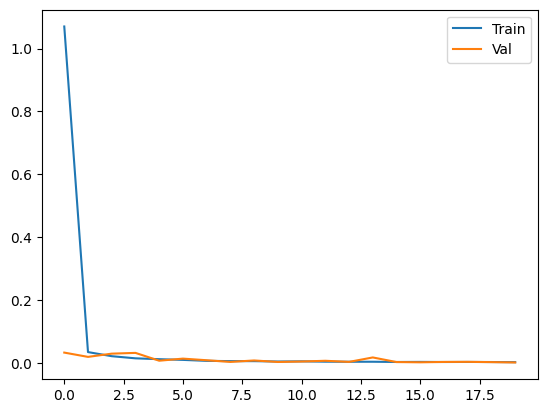

In [19]:
train_geometry_model(model_g, train_loader, val_loader, epochs=20)

In [20]:
# model_g.load_state_dict(torch.load("geo_model.pth"))
# model_g.eval()

# accumulate
preds, targs = [], []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model_g(data).cpu()
        preds.append(out)
        targs.append(data.y.cpu())

preds = torch.cat(preds)
targs = torch.cat(targs)

mse = criterion(preds, targs).item()
mae = nn.L1Loss()(preds, targs).item()
print(f"Geo Test (normalized) → MSE: {mse:.5f} | MAE: {mae:.5f}")

# denormalize
preds_act = preds * std + mu
targs_act = targs * std + mu
print(f"Geo Test (actual)     → MSE: {nn.MSELoss()(preds_act, targs_act):.5f} | MAE: {nn.L1Loss()(preds_act, targs_act):.5f}")

Geo Test (normalized) → MSE: 0.00124 | MAE: 0.02580
Geo Test (actual)     → MSE: 0.13226 | MAE: 0.26606


C:\Users\Andy\AppData\Local\Temp\ipykernel_9328\2958191090.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  preds_act = preds * std + mu
C:\Users\Andy\AppData\Local\Temp\ipykernel_9328\2958191090.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  targs_act = targs * std + mu


## Task 2

In [21]:
import random, torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [22]:
# sample the subset
def sample_subset_loader(full_idx, size, smiles_data, fe_tensor, token_to_idx, batch_size=64):
    subset_idx     = random.sample(list(full_idx), size)
    smiles_subset  = [smiles_data[i] for i in subset_idx]
    fe_subset      = fe_tensor[subset_idx]

    max_len = max(len(s) for s in smiles_subset)
    smiles_tensor = torch.zeros((size, max_len), dtype=torch.long)
    for i, seq in enumerate(smiles_subset):
        for j, tok in enumerate(seq):
            smiles_tensor[i, j] = token_to_idx.get(tok, 0)

    ds  = torch.utils.data.TensorDataset(smiles_tensor, fe_subset)
    dl  = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
    return dl

@torch.no_grad()
def evaluate_smiles(model, test_loader, mu, std):
    model.eval()
    preds, targets = [], []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds.append(model(x).cpu())
        targets.append(y.cpu())
    preds   = torch.cat(preds)
    targets = torch.cat(targets)

    mu_t, std_t = torch.tensor(mu), torch.tensor(std)
    preds   = preds * std_t + mu_t
    targets = targets * std_t + mu_t
    return (mean_absolute_error(targets, preds), r2_score(targets, preds))

In [23]:
# Smiles dataset
train_dataset = SmilesDataset(padded, fe_tensor, train_idxes)
val_dataset   = SmilesDataset(padded, fe_tensor, val_idxes)
test_dataset  = SmilesDataset(padded, fe_tensor, test_idxes)

BS = 128
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS)
test_loader = DataLoader(test_dataset, batch_size=BS)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 837
Validation batches: 93
Test batches: 79


In [24]:
# Smile
subset_sizes = [100, 300, 1000, 3000, 10000]
smiles_res   = {"size": [], "mae": [], "r2": []}

for n in subset_sizes:
    print(f"\nSMILES - {n}")
    train_dl = sample_subset_loader(train_idxes, n, smiles_data, fe_tensor, token_to_idx)
    val_dl   = sample_subset_loader(val_idxes, min(len(val_idxes), 1000), smiles_data, fe_tensor, token_to_idx)

    model_s = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
    train_smiles_model(model_s, train_dl, val_dl, epochs=10)

    mae, r2 = evaluate_smiles(model_s, test_loader, mu, std)
    smiles_res["size"].append(n); smiles_res["mae"].append(mae); smiles_res["r2"].append(r2)
    print(f"→ MAE={mae:.3f} | R-SQUARED={r2:.3f}")


SMILES - 100


Epoch 1/10:   0%|          | 0/2 [00:00<?, ?it/s, train_loss=0.965]

Epoch  1 | Train Loss: 0.9754 | Val Loss: 0.9913


Epoch  2 | Train Loss: 0.9754 | Val Loss: 0.9913


Epoch 3/10:   0%|          | 0/2 [00:00<?, ?it/s, train_loss=1.22] 

Epoch  3 | Train Loss: 0.9754 | Val Loss: 0.9913


Epoch  4 | Train Loss: 0.9754 | Val Loss: 0.9913


Epoch 5/10:   0%|          | 0/2 [00:00<?, ?it/s, train_loss=0.891]

Epoch  5 | Train Loss: 0.9754 | Val Loss: 0.9913


Epoch  6 | Train Loss: 0.9754 | Val Loss: 0.9913


Epoch 7/10:   0%|          | 0/2 [00:00<?, ?it/s, train_loss=0.939]

Epoch  7 | Train Loss: 0.9754 | Val Loss: 0.9913


Epoch  8 | Train Loss: 0.9754 | Val Loss: 0.9913


Epoch 9/10:   0%|          | 0/2 [00:00<?, ?it/s, train_loss=1.11] 

Epoch  9 | Train Loss: 0.9754 | Val Loss: 0.9913


Epoch 10 | Train Loss: 0.9754 | Val Loss: 0.9913
→ MAE=8.142 | R-SQUARED=-0.001

SMILES - 300


Epoch 1/10:   0%|          | 0/5 [00:00<?, ?it/s, train_loss=1.01] 

Epoch  1 | Train Loss: 1.0420 | Val Loss: 1.0251


Epoch  2 | Train Loss: 1.0420 | Val Loss: 1.0251


Epoch 3/10:   0%|          | 0/5 [00:00<?, ?it/s, train_loss=0.803]

Epoch  3 | Train Loss: 1.0420 | Val Loss: 1.0251


Epoch  4 | Train Loss: 1.0420 | Val Loss: 1.0251


Epoch 5/10:   0%|          | 0/5 [00:00<?, ?it/s, train_loss=1.05] 

Epoch  5 | Train Loss: 1.0420 | Val Loss: 1.0251


Epoch  6 | Train Loss: 1.0420 | Val Loss: 1.0251


Epoch 7/10:   0%|          | 0/5 [00:00<?, ?it/s, train_loss=1.16] 

Epoch  7 | Train Loss: 1.0420 | Val Loss: 1.0251


Epoch  8 | Train Loss: 1.0420 | Val Loss: 1.0251


Epoch 9/10:   0%|          | 0/5 [00:00<?, ?it/s, train_loss=0.987]

Epoch  9 | Train Loss: 1.0420 | Val Loss: 1.0251


Epoch 10 | Train Loss: 1.0420 | Val Loss: 1.0251
→ MAE=8.165 | R-SQUARED=-0.010

SMILES - 1000


Epoch 1/10:   0%|          | 0/16 [00:00<?, ?it/s, train_loss=1.08] 

Epoch  1 | Train Loss: 0.9407 | Val Loss: 0.9918


Epoch  2 | Train Loss: 0.9407 | Val Loss: 0.9918


Epoch 3/10:   0%|          | 0/16 [00:00<?, ?it/s, train_loss=0.76] 

Epoch  3 | Train Loss: 0.9407 | Val Loss: 0.9918


Epoch  4 | Train Loss: 0.9407 | Val Loss: 0.9918


Epoch 5/10:   0%|          | 0/16 [00:00<?, ?it/s, train_loss=0.997]

Epoch  5 | Train Loss: 0.9407 | Val Loss: 0.9918


Epoch  6 | Train Loss: 0.9407 | Val Loss: 0.9918


Epoch 7/10:   0%|          | 0/16 [00:00<?, ?it/s, train_loss=0.86] 

Epoch  7 | Train Loss: 0.9407 | Val Loss: 0.9918


Epoch  8 | Train Loss: 0.9407 | Val Loss: 0.9918


Epoch 9/10:   0%|          | 0/16 [00:00<?, ?it/s, train_loss=1.13] 

Epoch  9 | Train Loss: 0.9407 | Val Loss: 0.9918


Epoch 10 | Train Loss: 0.9407 | Val Loss: 0.9918
→ MAE=8.142 | R-SQUARED=-0.004

SMILES - 3000


Epoch 1/10:   0%|          | 0/47 [00:00<?, ?it/s, train_loss=1.03] 

Epoch  1 | Train Loss: 0.9665 | Val Loss: 1.0178


Epoch  2 | Train Loss: 0.9665 | Val Loss: 1.0178


Epoch 3/10:   0%|          | 0/47 [00:00<?, ?it/s, train_loss=1.19] 

Epoch  3 | Train Loss: 0.9665 | Val Loss: 1.0178


Epoch  4 | Train Loss: 0.9665 | Val Loss: 1.0178


Epoch 5/10:   0%|          | 0/47 [00:00<?, ?it/s, train_loss=0.699]

Epoch  5 | Train Loss: 0.9665 | Val Loss: 1.0178


Epoch  6 | Train Loss: 0.9665 | Val Loss: 1.0178


Epoch 7/10:   0%|          | 0/47 [00:00<?, ?it/s, train_loss=0.887]

Epoch  7 | Train Loss: 0.9665 | Val Loss: 1.0178


Epoch  8 | Train Loss: 0.9665 | Val Loss: 1.0178


Epoch 9/10:   0%|          | 0/47 [00:00<?, ?it/s, train_loss=0.952]

Epoch  9 | Train Loss: 0.9665 | Val Loss: 1.0178


Epoch 10 | Train Loss: 0.9665 | Val Loss: 1.0178
→ MAE=8.140 | R-SQUARED=-0.000

SMILES - 10000


Epoch 1/10:   0%|          | 0/157 [00:00<?, ?it/s, train_loss=1.93] 

Epoch  1 | Train Loss: 1.0008 | Val Loss: 1.0361


Epoch  2 | Train Loss: 1.0008 | Val Loss: 1.0361


Epoch 3/10:   0%|          | 0/157 [00:00<?, ?it/s, train_loss=0.482]

Epoch  3 | Train Loss: 1.0008 | Val Loss: 1.0361


Epoch  4 | Train Loss: 1.0008 | Val Loss: 1.0361


Epoch 5/10:   0%|          | 0/157 [00:00<?, ?it/s, train_loss=1.15] 

Epoch  5 | Train Loss: 1.0008 | Val Loss: 1.0361


Epoch  6 | Train Loss: 1.0008 | Val Loss: 1.0361


Epoch 7/10:   0%|          | 0/157 [00:00<?, ?it/s, train_loss=1.62] 

Epoch  7 | Train Loss: 1.0008 | Val Loss: 1.0361


Epoch  8 | Train Loss: 1.0008 | Val Loss: 1.0361


Epoch 9/10:   0%|          | 0/157 [00:00<?, ?it/s, train_loss=0.996]

Epoch  9 | Train Loss: 1.0008 | Val Loss: 1.0361


Epoch 10 | Train Loss: 1.0008 | Val Loss: 1.0361
→ MAE=8.134 | R-SQUARED=-0.001


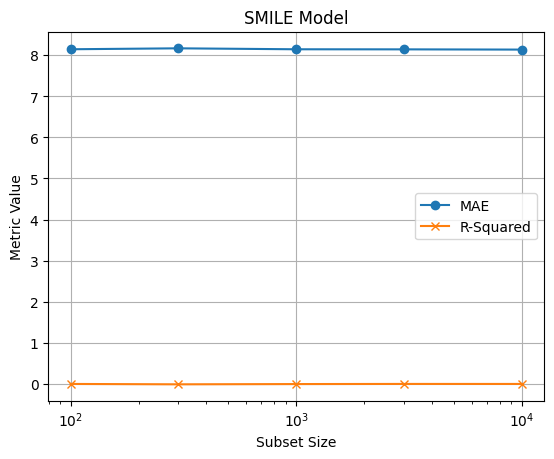

In [25]:
plt.figure()
plt.plot(smiles_res["size"], smiles_res["mae"], marker='o',  label="MAE")
plt.plot(smiles_res["size"], smiles_res["r2"],  marker='x',  label="R-Squared")
plt.xscale("log"); plt.xlabel("Subset Size")
plt.ylabel("Metric Value"); plt.title("SMILE Model")
plt.grid(True); plt.legend(); plt.show()


In [26]:
# GEOMETRY MODEL
import random, torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from torch_geometric.loader import DataLoader

random.seed(42); np.random.seed(42); torch.manual_seed(42)

In [27]:
def build_subset_graphs(indices):
    return [make_graph(i) for i in indices]

def get_graph_loader(graphs, batch=32, shuffle=True):
    return DataLoader(graphs, batch_size=batch, shuffle=shuffle)

@torch.no_grad()
def evaluate_geo(model, loader, mu, std):
    model.eval()
    preds, targets = [], []
    for data in loader:
        data = data.to(device)
        preds.append(model(data).cpu())
        targets.append(data.y.view(-1).cpu())
    preds   = torch.cat(preds)
    targets = torch.cat(targets)

    mu_t, std_t = torch.tensor(mu), torch.tensor(std)
    preds   = preds * std_t + mu_t
    targets = targets * std_t + mu_t
    return (mean_absolute_error(targets, preds),r2_score(targets, preds))

In [28]:
# Geometry dataset
train_graphs = [make_graph(i) for i in train_idxes]
val_graphs   = [make_graph(i) for i in val_idxes]
test_graphs  = [make_graph(i) for i in test_idxes]


from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=32)
test_loader  = DataLoader(test_graphs,  batch_size=32)


Geo - 100
Epoch 1 — Train: 231.2474 | Val: 7.7697
Epoch 2 — Train: 10.0148 | Val: 12.0420
Epoch 3 — Train: 16.5278 | Val: 31.6291
Epoch 4 — Train: 14.7960 | Val: 27.0702
Epoch 5 — Train: 10.0006 | Val: 2.3287
Epoch 6 — Train: 1.6335 | Val: 0.4264
Epoch 7 — Train: 0.5678 | Val: 2.5346
Epoch 8 — Train: 1.6517 | Val: 3.1970
Epoch 9 — Train: 1.5114 | Val: 3.8608
Epoch 10 — Train: 2.7417 | Val: 3.0349


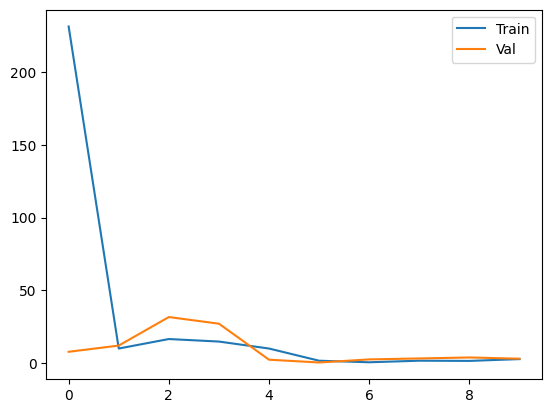

→ MAE=15.364 | R-SQUARED=-1.978

Geo - 300
Epoch 1 — Train: 161.9553 | Val: 0.8417
Epoch 2 — Train: 3.8674 | Val: 5.2313
Epoch 3 — Train: 3.8139 | Val: 0.7663
Epoch 4 — Train: 0.7448 | Val: 0.4623
Epoch 5 — Train: 1.6056 | Val: 1.9656
Epoch 6 — Train: 1.5868 | Val: 0.8516
Epoch 7 — Train: 0.5404 | Val: 2.1917
Epoch 8 — Train: 1.1942 | Val: 0.3251
Epoch 9 — Train: 0.3677 | Val: 0.3697
Epoch 10 — Train: 0.3787 | Val: 0.3743


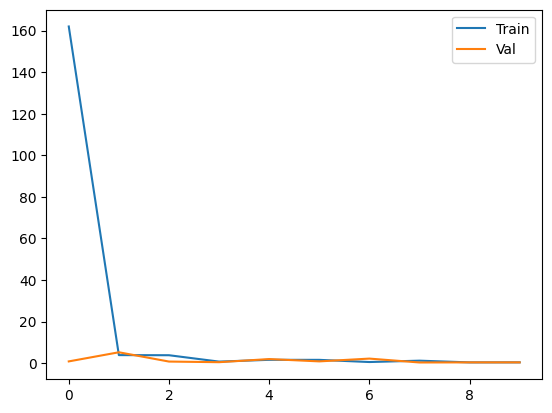

→ MAE=5.502 | R-SQUARED=0.627

Geo - 1000
Epoch 1 — Train: 145.6184 | Val: 0.6024
Epoch 2 — Train: 1.5613 | Val: 3.2415
Epoch 3 — Train: 1.0345 | Val: 0.9323
Epoch 4 — Train: 0.7574 | Val: 1.5996
Epoch 5 — Train: 0.6762 | Val: 0.4971
Epoch 6 — Train: 0.5585 | Val: 0.3150
Epoch 7 — Train: 0.5136 | Val: 0.8740
Epoch 8 — Train: 0.5328 | Val: 0.4592
Epoch 9 — Train: 0.5166 | Val: 0.3627
Epoch 10 — Train: 0.4636 | Val: 0.6877


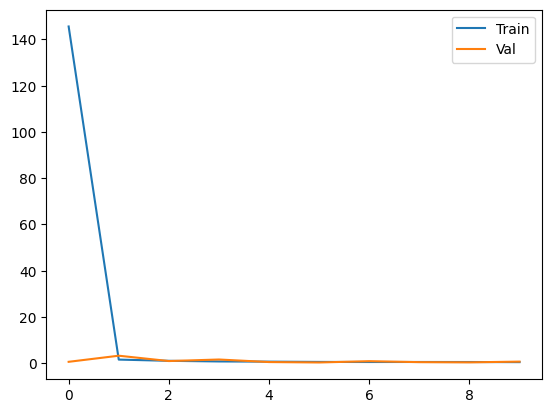

→ MAE=7.427 | R-SQUARED=0.317

Geo - 3000
Epoch 1 — Train: 18.2234 | Val: 0.7442
Epoch 2 — Train: 0.6390 | Val: 0.9573
Epoch 3 — Train: 0.5049 | Val: 0.3111
Epoch 4 — Train: 0.4211 | Val: 0.3084
Epoch 5 — Train: 0.3510 | Val: 0.3601
Epoch 6 — Train: 0.3964 | Val: 0.2121
Epoch 7 — Train: 0.3113 | Val: 0.2179
Epoch 8 — Train: 0.3766 | Val: 0.1738
Epoch 9 — Train: 0.4008 | Val: 0.8145
Epoch 10 — Train: 0.4657 | Val: 0.2156


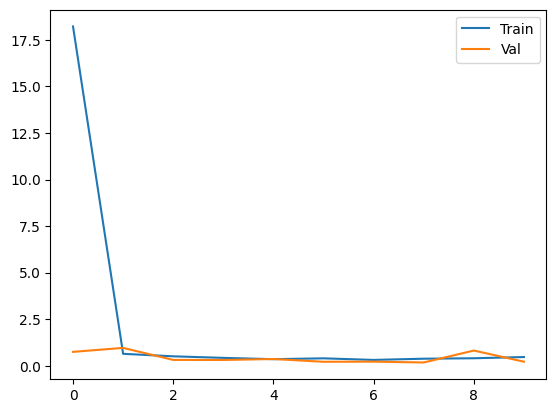

→ MAE=3.670 | R-SQUARED=0.785

Geo - 10000
Epoch 1 — Train: 7.9795 | Val: 0.2312
Epoch 2 — Train: 0.3755 | Val: 0.2695
Epoch 3 — Train: 0.3475 | Val: 0.2203
Epoch 4 — Train: 0.3023 | Val: 0.6106
Epoch 5 — Train: 0.2000 | Val: 0.1915
Epoch 6 — Train: 0.1599 | Val: 0.0505
Epoch 7 — Train: 0.1429 | Val: 0.0440
Epoch 8 — Train: 0.1152 | Val: 0.0343
Epoch 9 — Train: 0.0834 | Val: 0.0381
Epoch 10 — Train: 0.0616 | Val: 0.0391


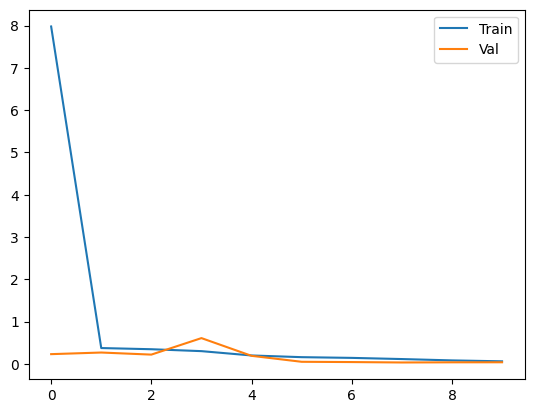

→ MAE=1.344 | R-SQUARED=0.970


In [29]:
subset_sizes = [100, 300, 1000, 3000, 10000]
geo_res      = {"size": [], "mae": [], "r2": []}

for n in subset_sizes:
    print(f"\nGeo - {n}")
    train_idx  = random.sample(list(train_idxes), n)
    train_dl   = get_graph_loader(build_subset_graphs(train_idx))
    model_g = GeometricEnergyPredictor().to(device)
    train_geometry_model(model_g, train_dl, val_loader, epochs=10, lr=1e-3)

    mae, r2 = evaluate_geo(model_g, test_loader, mu, std)
    geo_res["size"].append(n); geo_res["mae"].append(mae); geo_res["r2"].append(r2)
    print(f"→ MAE={mae:.3f} | R-SQUARED={r2:.3f}")

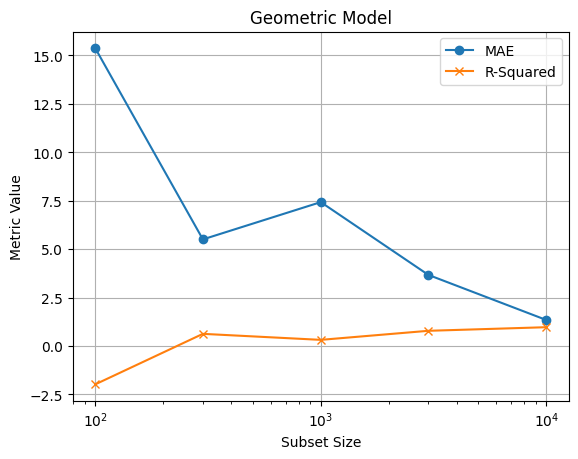

In [30]:
plt.figure()
plt.plot(geo_res["size"], geo_res["mae"], marker='o',  label="MAE")
plt.plot(geo_res["size"], geo_res["r2"],  marker='x',  label="R-Squared")
plt.xscale("log"); plt.xlabel("Subset Size")
plt.ylabel("Metric Value"); plt.title("Geometric Model")
plt.grid(True); plt.legend(); plt.show()

## Task 3

In [31]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [32]:
canonicalize("COO"), canonicalize("O(C)O")

('COO', 'COO')

In [33]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(True, True, False)

In [34]:
# Utility functions for SMILES validation and processing
def is_valid_smiles(smiles):
    """Check if SMILES string is chemically valid using RDKit."""
    if smiles is None or len(smiles) == 0:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    """Convert SMILES to canonical form."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return None
    except:
        return None

def clean_smiles(smiles):
    """Clean generated SMILES string."""
    # Remove padding tokens and unknown tokens
    cleaned = smiles.replace('<PAD>', '').replace('<UNK>', '').replace('<END>', '')
    return cleaned.strip()

# Enhanced vocabulary for generation (including special tokens)
def create_generation_vocab():
    """Create vocabulary specifically for SMILES generation."""
    # Get all unique characters from training SMILES
    all_chars = set()
    for smile in smiles_data:
        all_chars.update(smile)
    
    # Add special tokens for generation
    special_tokens = ['<PAD>', '<START>', '<END>', '<UNK>']
    vocab = special_tokens + sorted(list(all_chars))
    
    char_to_idx = {char: idx for idx, char in enumerate(vocab)}
    idx_to_char = {idx: char for idx, char in enumerate(vocab)}
    
    return vocab, char_to_idx, idx_to_char

# Create generation vocabulary
gen_vocab, char_to_idx, idx_to_char = create_generation_vocab()
print(f"Generation vocabulary size: {len(gen_vocab)}")
print(f"Vocabulary: {gen_vocab}")

# Create training set for quick novelty checking
training_smiles_set = set(smiles_data[i] for i in train_idxes)
print(f"Training set size for novelty check: {len(training_smiles_set)}")

Generation vocabulary size: 28
Vocabulary: ['<PAD>', '<START>', '<END>', '<UNK>', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '=', '@', 'C', 'F', 'H', 'N', 'O', '[', '\\', ']', 'c', 'n', 'o']
Training set size for novelty check: 106979


In [35]:
# Character-level LSTM Generator
class SMILESGenerator(nn.Module):
    """Character-level LSTM for autoregressive SMILES generation."""
    
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        """Forward pass for training."""
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        
        # LSTM forward
        output, hidden = self.lstm(embedded, hidden)  # (batch_size, seq_len, hidden_dim)
        
        # Apply dropout and linear layer
        output = self.dropout(output)
        logits = self.fc(output)  # (batch_size, seq_len, vocab_size)
        
        return logits, hidden
    
    def generate_smiles(self, max_length=100, temperature=0.8, start_token='<START>', end_token='<END>'):
        """Generate a single SMILES string."""
        self.eval()
        with torch.no_grad():
            # Initialize with start token
            current_token = char_to_idx[start_token]
            generated = [current_token]
            hidden = None
            
            for _ in range(max_length):
                # Prepare input
                x = torch.tensor([[current_token]], device=device)
                
                # Forward pass
                logits, hidden = self.forward(x, hidden)
                
                # Apply temperature sampling
                logits = logits[0, -1] / temperature
                probs = torch.softmax(logits, dim=-1)
                
                # Sample next token
                next_token = torch.multinomial(probs, 1).item()
                generated.append(next_token)
                
                # Check for end token
                if next_token == char_to_idx[end_token]:
                    break
                    
                current_token = next_token
            
            # Convert to SMILES string
            smiles = ''.join([idx_to_char[idx] for idx in generated[1:-1]])  # Remove START/END
            return clean_smiles(smiles)


In [36]:

# Data preparation for generative models
def prepare_generation_data(smiles_list, char_to_idx, max_len=None):
    """Prepare SMILES data for generative model training."""
    if max_len is None:
        max_len = max(len(s) for s in smiles_list) + 2  # +2 for START/END tokens
    
    sequences = []
    for smiles in smiles_list:
        # Add start and end tokens
        seq = ['<START>'] + list(smiles) + ['<END>']
        # Convert to indices
        seq_indices = [char_to_idx.get(char, char_to_idx['<UNK>']) for char in seq]
        # Pad to max length
        if len(seq_indices) < max_len:
            seq_indices.extend([char_to_idx['<PAD>']] * (max_len - len(seq_indices)))
        else:
            seq_indices = seq_indices[:max_len]
        sequences.append(seq_indices)
    
    return torch.tensor(sequences, dtype=torch.long)

# Training functions
def train_lstm_generator(model, train_data, val_data, epochs=25, lr=1e-3):
    """Train the LSTM generator."""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx['<PAD>'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Input and target (shifted by one)
            input_seq = batch[:, :-1]
            target_seq = batch[:, 1:]
            
            logits, _ = model(input_seq)
            loss = criterion(logits.reshape(-1, model.vocab_size), target_seq.reshape(-1))
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                input_seq = batch[:, :-1]
                target_seq = batch[:, 1:]
                
                logits, _ = model(input_seq)
                loss = criterion(logits.reshape(-1, model.vocab_size), target_seq.reshape(-1))
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/lstm_generator_best.pth')
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


In [37]:
# Get training SMILES
train_smiles = [smiles_data[i] for i in train_idxes[:50000]]  # Use subset for faster training
val_smiles = [smiles_data[i] for i in val_idxes[:5000]]

# Prepare data
train_gen_data = prepare_generation_data(train_smiles, char_to_idx)
val_gen_data = prepare_generation_data(val_smiles, char_to_idx, max_len=train_gen_data.size(1))

print(f"Training data shape: {train_gen_data.shape}")
print(f"Validation data shape: {val_gen_data.shape}")
print(f"Max sequence length: {train_gen_data.size(1)}")

# Create and train models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


lstm_generator = SMILESGenerator(
    vocab_size=len(gen_vocab),
    embed_dim=256,
    hidden_dim=512,
    num_layers=3,
    dropout=0.3
).to(device)

print(f"LSTM Generator parameters: {sum(p.numel() for p in lstm_generator.parameters()):,}")


Training data shape: torch.Size([50000, 64])
Validation data shape: torch.Size([5000, 64])
Max sequence length: 64
Using device: cuda
LSTM Generator parameters: 5,800,988


In [38]:

# Train LSTM generator
train_lstm_generator(lstm_generator, train_gen_data, val_gen_data, epochs=25, lr=1e-4)

Epoch  0 | Train Loss: 1.2691 | Val Loss: 0.8436
Epoch  5 | Train Loss: 0.6454 | Val Loss: 0.6162
Epoch 10 | Train Loss: 0.5925 | Val Loss: 0.5765
Epoch 15 | Train Loss: 0.5675 | Val Loss: 0.5614
Epoch 20 | Train Loss: 0.5520 | Val Loss: 0.5525


In [40]:
# Comprehensive generation and evaluation
def generate_and_evaluate(model, num_molecules=5000, batch_size=100):
    """Generate molecules and evaluate validity, uniqueness, and novelty."""
    # Load best model
    model.load_state_dict(torch.load('models/lstm_generator_best.pth', map_location=device)) 
    model.eval()
    
    generated_smiles = []
    valid_smiles = []
    unique_smiles = set()
    novel_smiles = set()
    
    print(f"Generating {num_molecules} molecules in batches of {batch_size}...")
    
    # Generate in batches
    num_batches = (num_molecules + batch_size - 1) // batch_size
    
    for batch_idx in tqdm(range(num_batches), desc="Generating"):
        batch_size_current = min(batch_size, num_molecules - batch_idx * batch_size)
        
        try:
            # Generate using LSTM
            batch_molecules = []
            for _ in range(batch_size_current):
                # Try different temperatures for diversity
                temp = np.random.uniform(0.6, 1.2)
                smiles = model.generate_smiles(max_length=80, temperature=temp)
                batch_molecules.append(smiles)

            
            # Process batch
            for smiles in batch_molecules:
                if smiles and len(smiles.strip()) > 0:
                    generated_smiles.append(smiles)
                    
                    # Check validity
                    if is_valid_smiles(smiles):
                        canonical = canonicalize(smiles)
                        if canonical:
                            valid_smiles.append(canonical)
                            unique_smiles.add(canonical)
                            
                            # Check novelty
                            if canonical not in training_smiles_set:
                                novel_smiles.add(canonical)
                                
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue
    
    # Calculate metrics
    num_generated = len(generated_smiles)
    num_valid = len(valid_smiles)
    num_unique = len(unique_smiles)
    num_novel = len(novel_smiles)
    
    validity = (num_valid / num_generated * 100) if num_generated > 0 else 0
    uniqueness = (num_unique / num_valid * 100) if num_valid > 0 else 0
    novelty = (num_novel / num_unique * 100) if num_unique > 0 else 0

    print(f"Generated molecules: {num_generated:,}")
    print(f"Valid molecules: {num_valid:,}")
    print(f"Unique valid molecules: {num_unique:,}")
    print(f"Novel molecules: {num_novel:,}")
    print(f"METRICS:")
    print(f"Validity: {validity:.2f}%")
    print(f"Uniqueness: {uniqueness:.2f}%")
    print(f"Novelty: {novelty:.2f}%")
    
    # Show some examples
    print(f"EXAMPLE GENERATED MOLECULES:")
    example_molecules = list(unique_smiles)[:10]
    for i, smiles in enumerate(example_molecules):
        print(f"{i+1:2d}. {smiles}")
    
    return {
        'generated': num_generated,
        'valid': num_valid,
        'unique': num_unique,
        'novel': num_novel,
        'validity': validity,
        'uniqueness': uniqueness,
        'novelty': novelty,
        'valid_smiles': valid_smiles,
        'unique_smiles': list(unique_smiles),
        'novel_smiles': list(novel_smiles)
    }

# Generate and evaluate with both models
lstm_results = generate_and_evaluate(lstm_generator, num_molecules=5000, batch_size=50)


Generating 5000 molecules in batches of 50...


Generating: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

Generated molecules: 5,000
Valid molecules: 4,793
Unique valid molecules: 4,700
Novel molecules: 2,061
METRICS:
Validity: 95.86%
Uniqueness: 98.06%
Novelty: 43.85%
EXAMPLE GENERATED MOLECULES:
 1. C1[C@@H]2CC3(CC3)C[C@H]12
 2. C[C@@]12C(=O)O[C@]13C[C@H]2C3
 3. Nc1nnoc1N1CC1
 4. [NH-]C1O[C@@]2(CO)CC[C@@H]12
 5. COCCC[C@H]1C[C@H]1C
 6. CC(=O)[C@@]1(C)N[C@H]1C#N
 7. C[C@@]12C[C@H]3[C@@H]4[C@@H]([C@@H]41)[C@H]32
 8. N#C[C@H]1CO[C@@H]2C[C@H]1O2
 9. C[C@@]12C[C@]1(O)[C@H]1C[C@@H]2C1
10. CO[C@H]1[C@@H](O)[C@H]1CO
